# Goodness of fit test for SV genes
This file is aiming to figure out whether SV genes follow a Possion or Normal distribution.

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm, trange
import scipy

In [2]:
def adata_preprocess(anndata,copy=True):
    if copy:
        anndata = anndata.copy()

    sc.pp.normalize_per_cell(anndata, counts_per_cell_after=10000)
    sc.pp.log1p(anndata)
    sc.pp.scale(anndata)
    # anndata.X = (anndata.X - anndata.X.mean(0)) / anndata.X.std(0)
    return anndata

In [3]:
def get_spatial_metrics(file_name):
    Crecord_dir = os.path.join('./recode/10XGenomics/',file_name,'geary/gearyC.test.csv')
    Irecord_dir = os.path.join('./recode/10XGenomics/',file_name,'moran/moranI.test.csv')
    Cs = pd.read_csv(Crecord_dir,index_col=0)[['C']]
    Is = pd.read_csv(Irecord_dir,index_col=0)[['I']]
    return pd.concat([Cs,Is],axis=1)

In [4]:
def poisson_dispersion_test(x):
    n = x.shape[0]
    D = np.std(x, axis=0) ** 2 / np.mean(x, axis=0) * n
    p = 2 * np.minimum(stats.chi2.sf(D, n - 1), stats.chi2.cdf(D, n - 1))
    return p

In [5]:
def vis_single(x,ax=None):
    if ax is None:
        f,ax = plt.subplots()
    ind, count = np.unique(x, return_counts=True)
    prob = count / count.sum()
    mu1 = x.mean()
    mu2 = x.std()**2
    k = np.arange(x.min(), x.max()+1)
    pmf1 = stats.poisson.pmf(k, mu1, loc=0)
    pmf2 = stats.poisson.pmf(k, mu2, loc=0) 
    
    p = poisson_dispersion_test(x)
    
    ax.plot(k,pmf1,color = sns.color_palette()[0],linestyle='--')
    ax.plot(k,pmf2,color = sns.color_palette()[1],linestyle='--')
    ax.bar(x = ind, height = prob,color='.5')
    ax.bar(x=[0],height=0,color='white')
    ax.legend(['$\mu=mean(obs)$','$\mu=var(obs)$','observed',f'p={p:.2f}'],edgecolor='white')
    ax.set_ylabel('Prob. density')

# Poisson

In [99]:
used_data_dirs = './data/10XGenomics/'
use_metric = 'I'
test_ratio = 1

result = []
files = [i for i in os.listdir(used_data_dirs) if i.endswith('h5ad')]
for file in tqdm(files):
    score = get_spatial_metrics(file)[use_metric]
    thres = score.quantile(1-test_ratio)
    high_spatial_variable = score.index[score >= thres]
    adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
    X = adata[:,high_spatial_variable].X.toarray()
    ps = pd.Series(np.apply_along_axis(arr = X,func1d=poisson_dispersion_test,axis=0),index=high_spatial_variable,name='p')
    ss = score[high_spatial_variable]
    
    result.append(pd.concat([ps,ss],axis=1))

result = pd.concat(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [05:39<00:00,  7.90s/it]


In [100]:
from statsmodels.stats.multitest import multipletests

rejects,fdrs,_,_ = multipletests(result.loc[:,'p'])
result['fdr'] = fdrs
f, ax = plt.subplots(dpi=300)
ax.scatter(
    fdrs,result.loc[:,'I'],
    alpha = 0.8,facecolors='none',edgecolors='.3',s=3
)
color = sns.color_palette("deep")[1]
ax.axvline(x=0.05, color=color, linestyle='--')
ax.text(0.06, 0.75, 'fdr=0.05', color=color,alpha=0.8)
ax.set_ylabel('moran\' I')
ax.set_xlabel('False Positive Rate')
f.savefig('./Results/Supp.I.Poisson.pdf',bbox_inches='tight')
f.savefig('./Results/Supp.I.Poisson.tiff',dpi=600,bbox_inches='tight')
result.to_csv('./Results/Supp.I.Poisson.csv')
plt.close(f)

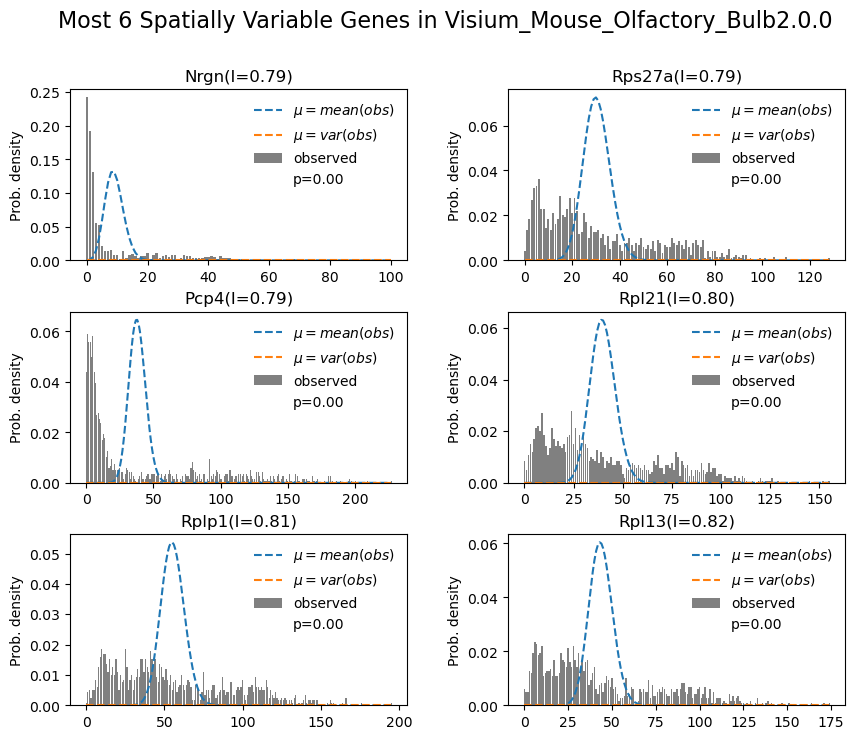

In [66]:
# example: for most and least Spatially variance
file = files[-1]
adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
score = get_spatial_metrics(file)[use_metric].dropna()
high_spatial_variable = score.sort_values().index[-6:]

f,axes = plt.subplots(3,2,figsize=(10,8))
plt.subplots_adjust(wspace=0.3,hspace=0.3)
axes = axes.flatten()
for i,gene in enumerate(high_spatial_variable.to_list()):
    vis_single(adata[:,gene].X.toarray().flatten(),ax = axes[i])
    axes[i].set_title(f"{gene}(I={score[gene]:.2f})")
f.suptitle(f"Most 6 Spatially Variable Genes in {file.replace('.h5ad','')}",fontsize=16)
f.savefig('./Results/Supp.Example.Poisson_SV.pdf',bbox_inches='tight')

# Normal

In [95]:
used_data_dirs = './data/10XGenomics/'
use_metric = 'I'
test_ratio = 0.01

result = []
files = [i for i in os.listdir(used_data_dirs) if i.endswith('h5ad')]
for file in tqdm(files):
    adata = sc.read_h5ad(os.path.join(used_data_dirs,file))
    adata = adata_preprocess(adata)
    score = get_spatial_metrics(file)[use_metric]
    thres = score.quantile(1-test_ratio)
    high_spatial_variable = score.index[score >= thres]
    X = adata[:,high_spatial_variable].X.toarray()
    ps = pd.Series(stats.normaltest(adata[:,high_spatial_variable].X.toarray(),axis=0).pvalue,index=high_spatial_variable,name='p')
    ss = score[high_spatial_variable]
    
    result.append(pd.concat([ps,ss],axis=1))

result = pd.concat(result)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [01:36<00:00,  2.24s/it]


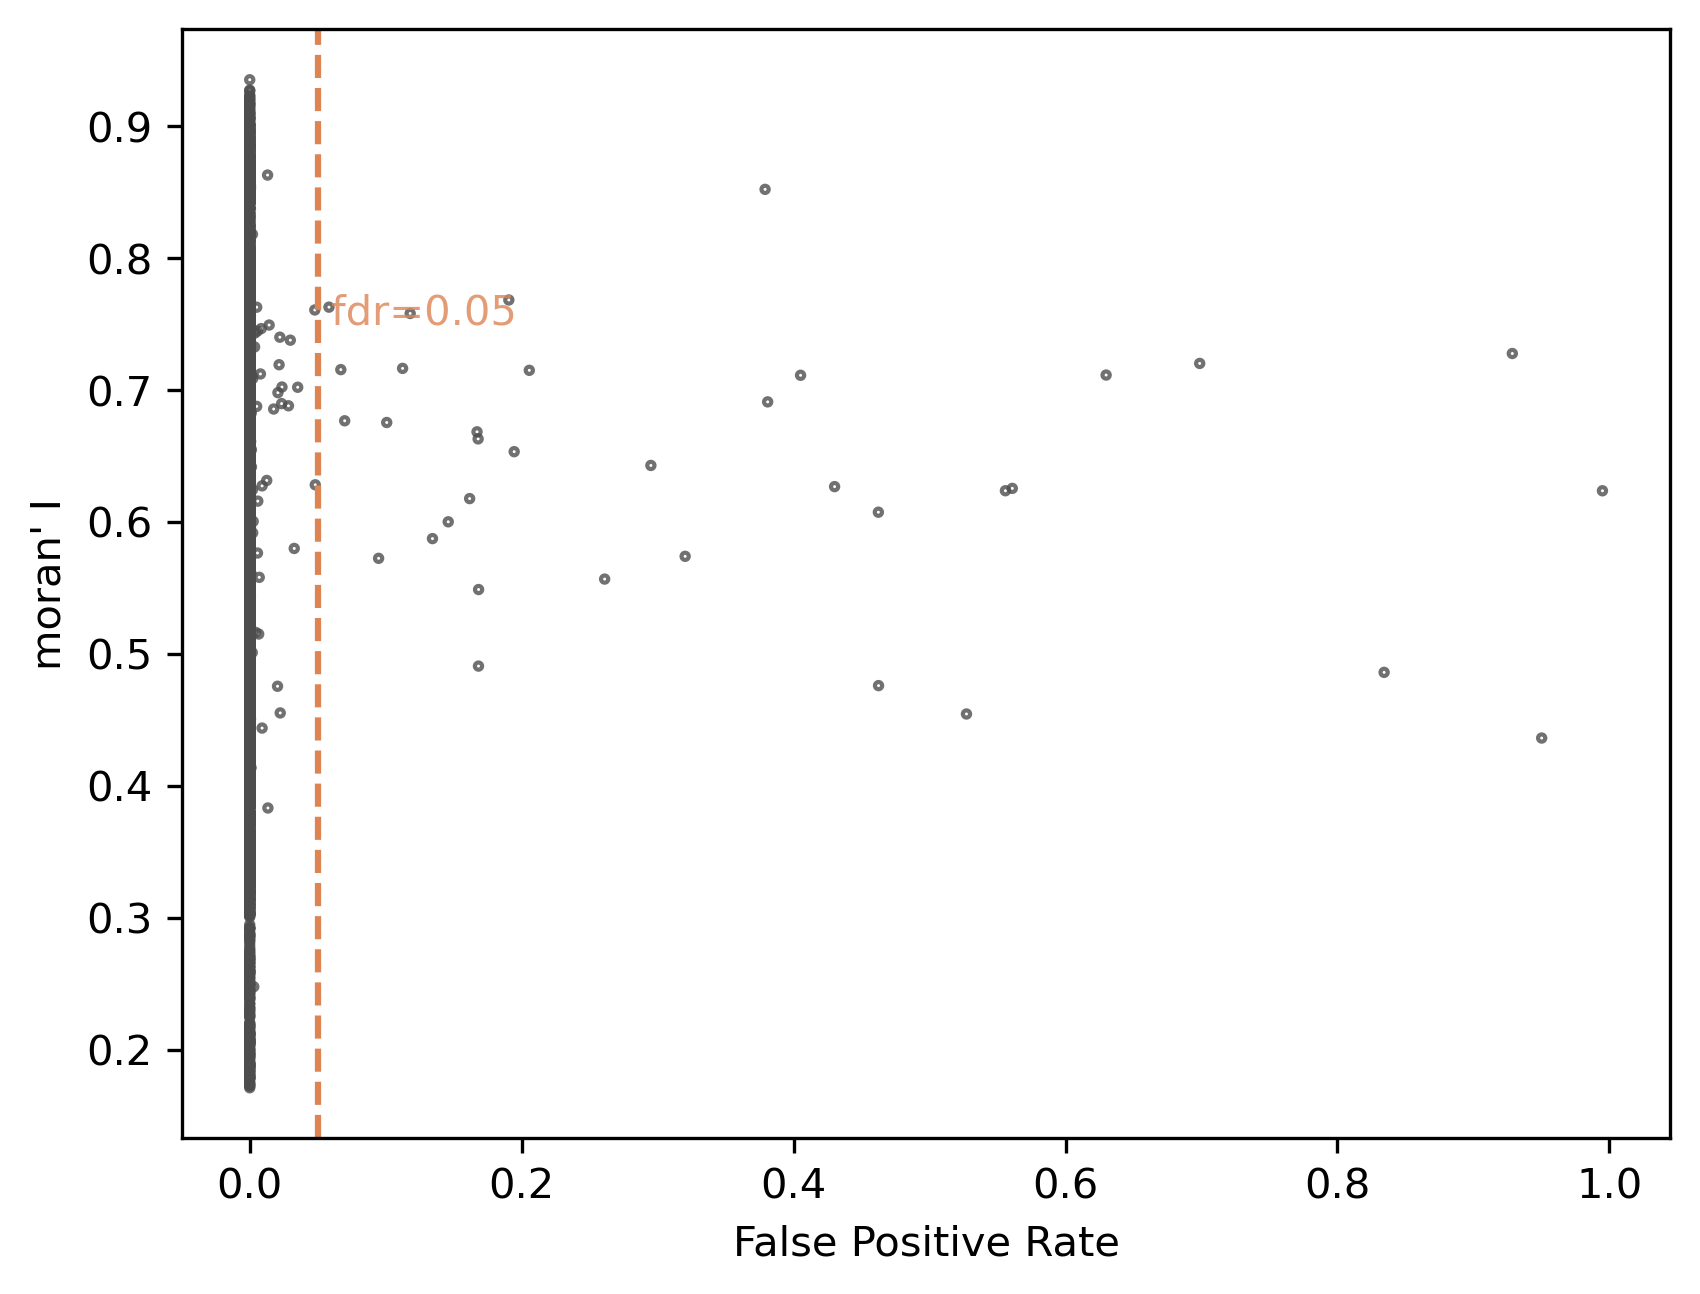

In [98]:
from statsmodels.stats.multitest import multipletests

rejects,fdrs,_,_ = multipletests(result.loc[:,'p'])
result['fdr'] = fdrs
f, ax = plt.subplots(dpi=300)
ax.scatter(
    result.loc[:,'p'],result.loc[:,'I'],
    alpha = 0.8,facecolors='none',edgecolors='.3',s=3
)
color = sns.color_palette("deep")[1]
ax.axvline(x=0.05, color=color, linestyle='--')
ax.text(0.06, 0.75, 'fdr=0.05', color=color,alpha=0.8)
ax.set_ylabel('moran\' I')
ax.set_xlabel('False Positive Rate')
f.savefig('./Results/Supp.I.Norm.TOP1.pdf',bbox_inches='tight')
f.savefig('./Results/Supp.I.Norm.TOP1.tiff',dpi=600,bbox_inches='tight')
result.to_csv('./Results/Supp.I.Norm.TOP1.csv')
# plt.close(f)

# A example 

In [6]:
used_data_dirs = './data/10XGenomics/'
use_metric = 'I'
test_ratio = 1

files = [i for i in os.listdir(used_data_dirs) if i.endswith('h5ad')]
file = files[-1]
adata = sc.read_h5ad(os.path.join(used_data_dirs,file))

score = get_spatial_metrics(file)[use_metric]
thres = score.quantile(1-test_ratio)
high_spatial_variable = score.index[score >= thres]
X = adata[:,high_spatial_variable].X.toarray()
ps = pd.Series(np.apply_along_axis(arr = X,func1d=poisson_dispersion_test,axis=0),index=high_spatial_variable,name='p')
ss = score[high_spatial_variable]

poi_res = pd.concat([ps,ss],axis=1)

adata = adata_preprocess(adata)
score = get_spatial_metrics(file)[use_metric]
thres = score.quantile(1-test_ratio)
high_spatial_variable = score.index[score >= thres]
X = adata[:,high_spatial_variable].X.toarray()
ps = pd.Series(stats.normaltest(adata[:,high_spatial_variable].X.toarray(),axis=0).pvalue,index=high_spatial_variable,name='p')
ss = score[high_spatial_variable]
    
norm_res = pd.concat([ps,ss],axis=1)

Visium_Mouse_Olfactory_Bulb2.0.0.h5ad


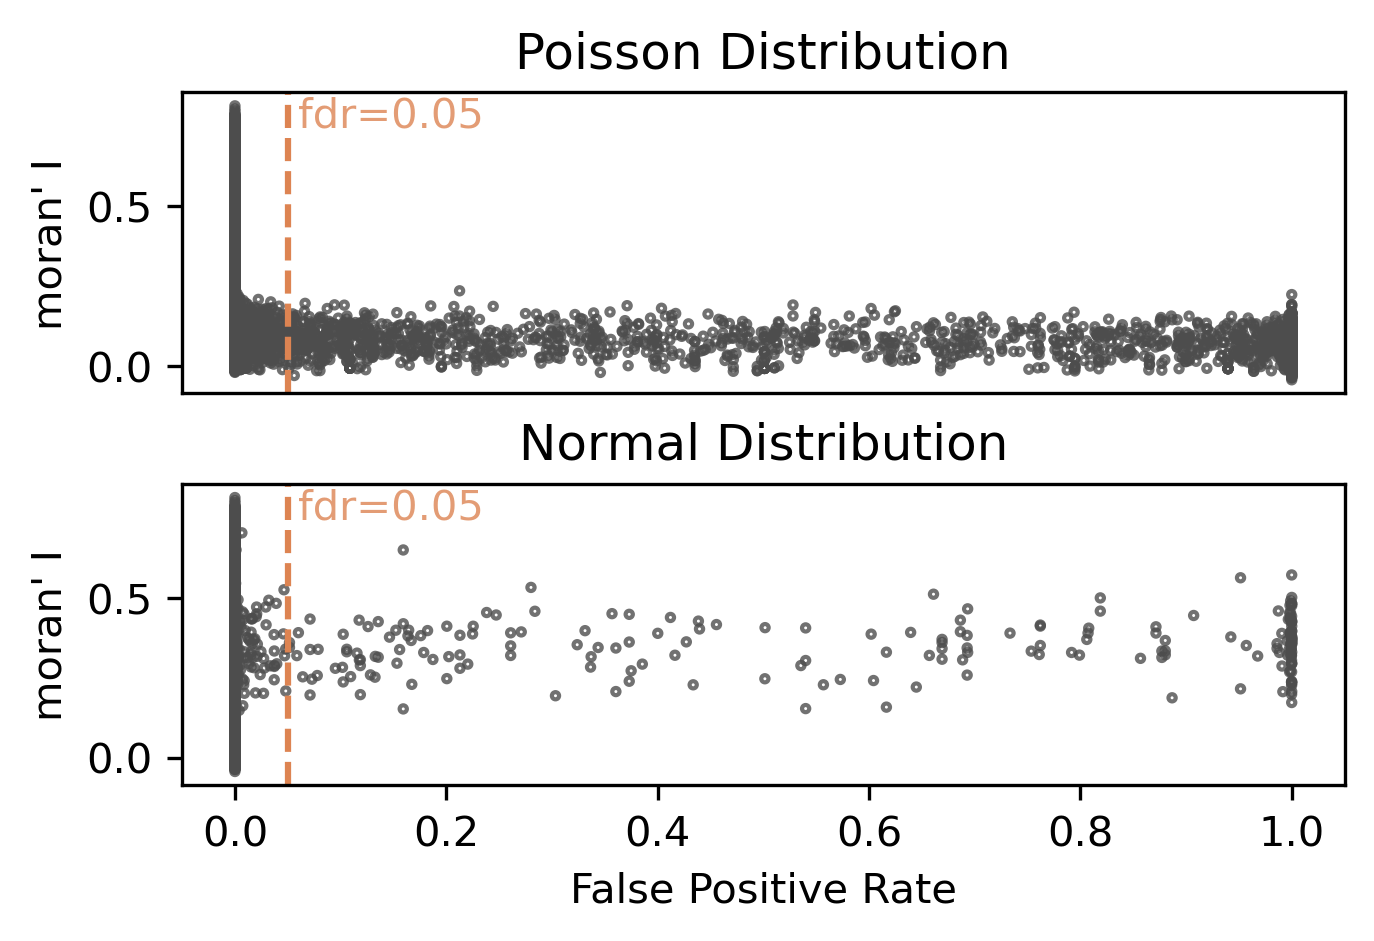

In [12]:
from statsmodels.stats.multitest import multipletests
print(file)
def fdr_cal(result):
    rejects,fdrs,_,_ = multipletests(result.loc[:,'p'])
    result['fdr'] = fdrs
    

f, axes = plt.subplots(2,1,dpi=300,figsize=(5,3))
plt.subplots_adjust(hspace=0.3)
for ax,result in zip(axes,[poi_res,norm_res]):
    fdr_cal(result)
    ax.scatter(
        result.loc[:,'fdr'],result.loc[:,'I'],
        alpha = 0.8,facecolors='none',edgecolors='.3',s=3
    )
    color = sns.color_palette("deep")[1]
    ax.axvline(x=0.05, color=color, linestyle='--')
    ax.text(0.06, 0.75, 'fdr=0.05', color=color,alpha=0.8)
    ax.set_ylabel('moran\' I')
    ax.set_xlabel('False Positive Rate')
axes[0].set_xticks([])
axes[0].set_xlabel('')
axes[0].set_title('Poisson Distribution',)
axes[1].set_title('Normal Distribution',)
f.savefig('./Results/Example.SV.Dist.pdf',bbox_inches='tight')
f.savefig('./Results/Example.SV.Dist.tiff',dpi=600,bbox_inches='tight')
# plt.close(f)